# General workflow demonstration

## Setup and configuration

In [1]:
# Install dependencies not in the base jupyter image

import sys
!conda install -q -y -c conda-forge --prefix {sys.prefix} ipyleaflet

# If you have JupyterLab, you will also need to install the JupyterLab extension:
# jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import ipyleaflet
from birdy import WPSClient

# we will use these coordinates later to center the map on Canada
canada_center_lat_lon = (52.4292, -93.2959)

#### Pavics url configuration

In [3]:
# pavics.ouranos.ca
# pavics_url = "https://pavics.ouranos.ca"
# finch_url = f'{pavics_url}/twitcher/ows/proxy/finch/wps'

# colibri
# Important note: this is a development server, uptime is not guaranteed
pavics_url = "https://colibri.crim.ca"
finch_url = f"{pavics_url}/twitcher/ows/proxy/finch/wps"

## Getting user input from a map widget

### Notes about ipyleaflet

ipyleaflet is a **"A Jupyter / Leaflet bridge enabling interactive maps in the Jupyter notebook"**

This means that the interactions with graphical objects on the map and in python are synchronized. The documentation is at: https://ipyleaflet.readthedocs.io

In [4]:
leaflet_map = ipyleaflet.Map(
    center=canada_center_lat_lon,
    basemap=ipyleaflet.basemaps.Stamen.Terrain,
    zoom=4,
)

initial_marker_location = canada_center_lat_lon
marker = ipyleaflet.Marker(location=initial_marker_location, draggable=True)
leaflet_map.add_layer(marker)

leaflet_map

Map(basemap={'url': 'https://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', 'attribution': 'Map til…

If you move the marker on the map, it will update the `marker.location` variable. Also, if you update `marker.location` manually (`marker.location = (45.44, -90.44)`) it will also move on the map.

In [7]:
marker.location = (45.55, -72.44)

In [6]:
print(initial_marker_location)
print(marker.location)

(52.4292, -93.2959)
[52.28282434012458, -106.0440355539322]


#### Helper function to get user input

In [8]:
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets

def get_rectangle():
    canada_center = (52.4292, -93.2959)
    m = ipyleaflet.Map(
        center=canada_center,
        basemap=ipyleaflet.basemaps.Stamen.Terrain,
        zoom=4,
    )
    
    # Create a new draw control
    draw_control = ipyleaflet.DrawControl()

    # disable some drawing inputs
    draw_control.polyline = {}
    draw_control.circlemarker = {}
    draw_control.polygon = {}

    draw_control.rectangle = {
        "shapeOptions": {
            "fillColor": "#4ae",
            "color": "#4ae",
            "fillOpacity": 0.3,
        }
    }

    output = widgets.Output(layout={'border': '1px solid black'})
    
    rectangle = {}

    # set drawing callback
    def callback(control, action, geo_json):
        if action == "created":
            # note: we can't close the map or remove it from the output
            # from this callback. The map keeps the focus, and the 
            # jupyter keyboard input is messed up.
            # So we set it very thin to make it disappear :)
            m.layout = {"max_height": "0"}
            with output:
                print("*User selected 1 rectangle*")
                rectangle.update(geo_json)

    draw_control.on_draw(callback)    

    m.add_control(draw_control)
    
    with output:
        print("Select a rectangle:")
        display(m)
        
    display(output)
    
    return rectangle

#### The user wants to select a rectangle on a map, and get a GeoJSON back

In [9]:
rectangle = get_rectangle()

Output(layout=Layout(border='1px solid black'))

In [10]:
rectangle  # GeoJSON with custom style properties

{'type': 'Feature',
 'properties': {'style': {'stroke': True,
   'color': '#4ae',
   'weight': 4,
   'opacity': 0.5,
   'fill': True,
   'fillColor': '#4ae',
   'fillOpacity': 0.3,
   'clickable': True}},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-91.689606, 47.597073],
    [-91.689606, 52.951345],
    [-82.028825, 52.951345],
    [-82.028825, 47.597073],
    [-91.689606, 47.597073]]]}}

#### Get the maximum and minimum bounds

In [11]:
import geopandas as gpd

rect = gpd.GeoDataFrame.from_features([rectangle])
bounds = rect.bounds
bounds

,minx,miny,maxx,maxy
0,-91.689606,47.597073,-82.028825,52.951345


## Calling wps processes

For this example, we will **subset** a dataset with the user-selected bounds, and launch a **heat wave frequency** analysis on it.

In [12]:
finch = WPSClient(finch_url, progress=True)

In [13]:
help(finch.subset_bbox)

Help on method subset_bbox in module birdy.client.base:

subset_bbox(resource=None, lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0, y0=None, y1=None, variable=None) method of birdy.client.base.WPSClient instance
    Return the data for which grid cells intersect the bounding box for each input dataset as well as the time range selected.
    
    Parameters
    ----------
    resource : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF files, can be OPEnDAP urls.
    lon0 : float
        Minimum longitude.
    lon1 : float
        Maximum longitude.
    lat0 : float
        Minimum latitude.
    lat1 : float
        Maximum latitude.
    y0 : integer
        Initial year for temporal subsetting. Defaults to first year in file.
    y1 : integer
        Final year for temporal subsetting. Defaults to last year in file.
    variable : string
        Name of the variable in the NetCDF file.If not provided, all variables will be subsetted.
    
    R

### Subset tasmin and tasmax datasets

#### Note: the datasets will soon be made searchable through a catalog

In [14]:
tasmin = "http://colibri.crim.ca:8083/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/nrcan_canada_daily_tasmin_1958.nc"
tasmax = "http://colibri.crim.ca:8083/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily/nrcan_canada_daily_tasmax_1958.nc"
lon0 = float(bounds.minx)
lon1 = float(bounds.maxx)
lat0 = float(bounds.miny)
lat1 = float(bounds.maxy)


In [15]:
result_tasmin = finch.subset_bbox(resource=tasmin, lon0=lon0, lon1=lon1, lat0=lat0, lat1=lat1)

In [16]:
# wait for process to complete before running this cell (the process is async)
tasmin_subset = result_tasmin.get().output
tasmin_subset

'https://colibri.crim.ca/wpsoutputs/8bb83582-db15-11e9-bed5-0242ac130004/nrcan_canada_daily_tasmin_1958_sub.nc'

In [17]:
result_tasmax = finch.subset_bbox(resource=tasmax, lon0=lon0, lon1=lon1, lat0=lat0, lat1=lat1)

In [18]:
# wait for process to complete before running this cell (the process is async)
tasmax_subset = result_tasmax.get().output
tasmax_subset

'https://colibri.crim.ca/wpsoutputs/919127de-db15-11e9-bed5-0242ac130004/nrcan_canada_daily_tasmax_1958_sub.nc'

### Launch a heat wave frequency analysis with the subsetted datasets

In [19]:
help(finch.heat_wave_frequency)

Help on method heat_wave_frequency in module birdy.client.base:

heat_wave_frequency(tasmin=None, tasmax=None, thresh_tasmin='22.0 degC', thresh_tasmax='30 degC', window=3, freq='YS') method of birdy.client.base.WPSClient instance
    Number of heat waves over a given period. A heat wave is defined as an event
        where the minimum and maximum daily temperature both exceeds specific thresholds
        over a minimum number of days.
    
    Parameters
    ----------
    tasmin : ComplexData:mimetype:`application/x-netcdf`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    tasmax : ComplexData:mimetype:`application/x-netcdf`
        NetCDF Files or archive (tar/zip) containing netCDF files.
    thresh_tasmin : string
        threshold
    thresh_tasmax : string
        threshold
    window : integer
        window
    freq : {'YS', 'MS', 'QS-DEC', 'AS-JUL'}string
        Resampling frequency
    
    Returns
    -------
    output_netcdf : ComplexData:mimetype:`a

In [20]:
result = finch.heat_wave_frequency(tasmin=tasmin_subset, tasmax=tasmax_subset, thresh_tasmin="14C", thresh_tasmax="22C")

Get the output as a python object (xarray Dataset)

In [21]:
ds, logs = result.get(asobj=True)

In [22]:
ds

<xarray.Dataset>
Dimensions:              (lat: 64, lon: 116, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 1958-01-01
  * lon                  (lon) float32 -91.625 -91.54167 ... -82.125 -82.04167
  * lat                  (lat) float32 52.875 52.791668 ... 47.708332 47.625
Data variables:
    heat_wave_frequency  (time, lat, lon) float64 ...
Attributes:
    Conventions:                     CF-1.5
    title:                           NRCAN 10km Gridded Climate Dataset
    history:                         2012-10-22T09:11:24: Convert from origin...
    institution:                     NRCAN
    source:                          ANUSPLIN
    redistribution:                  Redistribution policy unknown. For inter...
    DODS_EXTRA.Unlimited_Dimension:  time

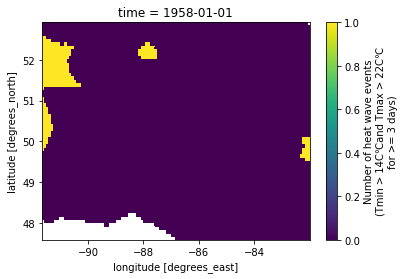

In [24]:
ds.heat_wave_frequency.isel(time=0).plot()

### Showing wms layers on a map

The results are stored in a folder that is available to thredds, which provides a WMS service to its datasets. In the case of large outputs, the user could view ths results of the analysis as a wms service without downloading the data.

#### Get the wms url from the 'wpsoutputs'

In [25]:
output_url = result.get().output_netcdf
print("output_url = ", output_url)
output_path = output_url[output_url.find("wpsoutputs"):]
output_path = output_path.replace("wpsoutputs", "wps_outputs")
print("output_path = ", output_path)

output_thredds_url = f"{pavics_url}:8083/thredds/wms/birdhouse/{output_path}"
output_thredds_url

output_url =  https://colibri.crim.ca/wpsoutputs/9ecf08c6-db15-11e9-bed5-0242ac130004/out.nc
output_path =  wps_outputs/9ecf08c6-db15-11e9-bed5-0242ac130004/out.nc


'http://colibri.crim.ca:8083/thredds/wms/birdhouse/wps_outputs/9ecf08c6-db15-11e9-bed5-0242ac130004/out.nc'

Using ipyleaflet again, we can connect to this wms service.

In [26]:
def show_wms(url):
    canada_center = (52.4292, -93.2959)
    
    wms = ipyleaflet.WMSLayer(
        url=url,
        layers="heat_wave_frequency",
        styles="boxfill/ferret",
        format="image/png",
        transparent=True,
        opacity=1,
        version="1.3.0",
    )
    basemap_layer = ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.Stamen.Terrain)
    m = ipyleaflet.Map(
        layers=(basemap_layer, wms),
        center=canada_center,
        zoom=4,
    )
    return m
    
m = show_wms(output_thredds_url)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …